<a href="https://colab.research.google.com/github/manumeehl/trajectories/blob/main/trajectories.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!apt install tesseract-ocr
!pip install opencv-python-headless pytesseract pytube

In [17]:
from google.colab.patches import cv2_imshow as show
import matplotlib.pyplot as plt
from pytube import YouTube
import pandas as pd
import pytesseract
import math
import cv2
import re

In [ ]:
''' Video Tools '''
def get_video(url, path):
  vid = YouTube(url)
  print(f"Downloading Video '{vid.streams[0].title}'")
  vid.streams.filter(progressive=True, file_extension='mp4').order_by('resolution').desc().first().download(output_path=path, filename='launch.mp4')
  print('Download complete')

In [ ]:
''' Image modification tools '''

def crop_roi(frame, roi):
  ''' Extract from a list of predefined regions of interest (ROI) '''
  height, width, _ = frame.shape

  if roi == 'Clock':
    return frame[height-110:height-20,int(width/2-200):int(width/2+200)]
  if roi == 'Stage 1':
    return frame[height-80:height-40,50:300]
  elif roi == 'Stage 2':
    return frame[height-120:height-20,width-300:width]

In [ ]:
''' Conversion tools '''
def clock_to_secs(clockstring):
  ''' Convert a mission clock string to an integer second value '''
  tense = -1 if clockstring[:2] == 't-' else 1
  # Remove the T+- sign
  clockstring = clockstring [2:]
  # Get the seconds
  units = clockstring.split(':')
  hours = int(units[0])
  minutes = int(units[1])
  seconds = int(units[2])

  return hours * 3600 + minutes * 60 + seconds

def frame_to_elapsed(framepos):
  # Calculate the exact time since liftoff based on the current frame
  return  round((framepos - liftoff_frame) / fps, 2)

In [ ]:
def get_trajectory_from_string(string):
  ''' Extract altitude and velocity from a given string '''
  string = string.lower()
  output = {}

  # Apply a blacklist
  blacklist = ['stage 1', 'stage 2', 'falcon 9', 'starlink']
  for w in blacklist:
    string = string.replace(w, '')

  # Find all numbers and floats in the string
  numbers = re.findall(r'\d+(?:\.\d+)?', string)
  numbers = list(set([float(x) for x in numbers]))
  if numbers:  output =  {'Altitude': min(numbers), 'Velocity': max(numbers)}
  return output

def get_clock_from_string(string):
  ''' Extract mission clock, altitude and velocity from a given string '''
  string = string.lower()
  output = {}

  # Find the mission clock (T+00:00:00)
  mission_clock = re.findall(r't[+-]\d{2}:\d{2}:\d{2}', string)

  if mission_clock: output =  {'Clock': mission_clock[0]}
  return output

In [ ]:
def extract_data(frame):
  ''' Pre-process frames and extract the data '''
  # Extract telemetry of Stage 1
  crop = crop_roi(frame, 'Stage 1')
  gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
  inverted = cv2.bitwise_not(gray)
  trajectory = get_trajectory_from_string(
      pytesseract.image_to_string(inverted, config='--psm 11'))

  # Extract telemetry of the Mission Clock
  crop = crop_roi(frame, 'Clock')
  gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
  inverted = cv2.bitwise_not(gray)
  clock = get_clock_from_string(
      pytesseract.image_to_string(inverted))

  return {**clock, **trajectory}

In [ ]:
def await_liftoff():
  ''' Identify the frame at which liftoff occurs '''
  framepos = 0
  interval = 300
  clock = ''
  # Await first mission clock appearance
  while vid.isOpened():
    vid.set(cv2.CAP_PROP_POS_FRAMES, int(framepos))
    framepos += interval

    ret, frame = vid.read()
    data = extract_data(frame)

    if 'Clock' in data.keys():
      clock = data['Clock']
      break

  # Now wait until the next full second
  interval = 1
  while vid.isOpened():
    vid.set(cv2.CAP_PROP_POS_FRAMES, int(framepos))
    framepos += interval

    ret, frame = vid.read()
    data = extract_data(frame)

    if 'Clock' in data.keys() and data['Clock'] != clock:
      framepos += int(clock_to_secs(data['Clock']) * fps)
      return framepos


In [ ]:
''' Fetch the trajectory via OCR '''
def process_launch(vid, liftoff_frame):
  framepos = liftoff_frame
  trajectory = pd.DataFrame(columns = ['Clock', 'Elapsed', 'Altitude', 'Velocity'])

  while vid.isOpened():
    vid.set(cv2.CAP_PROP_POS_FRAMES, int(framepos))
    ret, frame = vid.read()
    data = extract_data(frame)

    if 'Clock' in data.keys() and 'Velocity' in data.keys() and 'Altitude' in data.keys():
      # Save data
      data['Elapsed'] = round((framepos - liftoff_frame) / fps, 1)
      trajectory.loc[len(trajectory)] = data
      # Skip to next second
      framepos += int(fps - ((framepos - liftoff_frame) % fps)) + 3
    else:
      framepos += 3
    if framepos > liftoff_frame + (60*fps):
      break

  return trajectory


In [ ]:
# Fetch file from youtube
url = 'https://www.youtube.com/watch?v=agYuEAkEljw'
get_video(url, 'launches')

Download complete


In [ ]:
# Fetch local file
vidpath = 'launches/launch.mp4'
vid = cv2.VideoCapture(vidpath)
fps = vid.get(cv2.CAP_PROP_FPS)

print('Awaiting liftoff')
liftoff_frame = await_liftoff()
print('Liftoff registered, now monitoring launch')
trajectory = process_launch(vid, liftoff_frame)

Awaiting liftoff
Liftoff registered, now monitoring launch


In [ ]:
''' Data Post-Processing '''
def smooth_curve(curve):
  ''' Correct decimal errors of the OCR algorithm '''
  for i in range(len(curve[1:])):
    # Avoid zero-divisions
    if curve[i] == 0: curve[i] = 0.1
    if curve[i+1] / curve[i] > 2:
      curve[i+1] /= 10
    elif curve[i+1] / curve[i] < 0.5:
      curve[i+1] *= 10
  return curve

trajectory['Altitude (corrected)'] = smooth_curve(trajectory['Altitude'].values.tolist())
trajectory.to_csv('trajectory.csv')

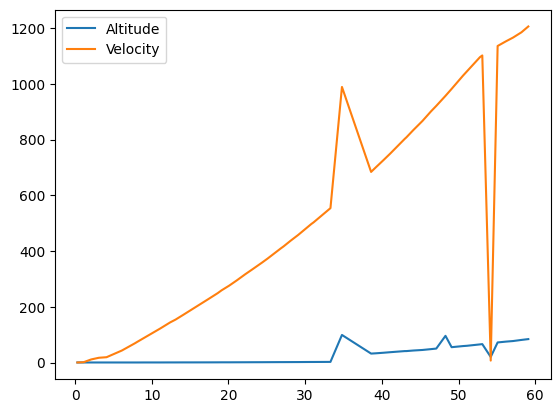

In [18]:
''' Data plots '''
x = trajectory['Elapsed'].values.tolist()
plt.plot(x, trajectory['Altitude'].values.tolist(), label='Altitude')
plt.plot(x, trajectory['Velocity'].values.tolist(), label='Velocity')

plt.legend()
plt.show()